## MADlib Greenplum Demo
---

### Import neccessary Data Science libraries

In [1]:
%matplotlib widget
import warnings
warnings.filterwarnings("ignore")

import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
pd.set_option('display.max_columns', 200)

Connect to Greenplum Database

In [2]:
%load_ext sql

In [3]:
!minikube service list

|----------------------|------------------------------------------------------|--------------|------------------------------|
|      NAMESPACE       |                         NAME                         | TARGET PORT  |             URL              |
|----------------------|------------------------------------------------------|--------------|------------------------------|
| default              | agent                                                | No node port |
| default              | greenplum                                            | psql/5432    | http://192.168.133.128:31763 |
| default              | greenplum-validating-webhook-service-9d44d9fcf-g5blg | No node port |
| default              | kubernetes                                           | No node port |
| default              | my-greenplum-pl                                      | No node port |
| default              | my-greenplum-pxf                                     | No node port |
| kube-system        

In [4]:
%sql postgresql://gpadmin@192.168.133.128:31763/db

        
%sql SELECT version();

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.


version
"PostgreSQL 9.4.24 (Greenplum Database 6.11.2 build commit:d611e78af2c5a6561ccbbaf2b4652138410f9aeb) on x86_64-unknown-linux-gnu, compiled by gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0, 64-bit compiled on Sep 30 2020 05:25:08"


### Check Database Data

In [5]:
%%sql


SELECT COUNT(*) AS num_sample FROM sensors;

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.


num_sample
200000


In [6]:
%%sql

SELECT * FROM sensors LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:31763/db
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,power
1997-03-22 00:00:00,30.3733285100443,20.1327062735142,40.9939663916248,75.6570296541207,79.2376084600628
1997-03-22 04:00:00,31.1390358048566,19.3834427364218,72.0293369088366,99.2363478747728,81.9934738749788
1997-03-22 12:00:00,31.0539896532603,20.1146776773216,38.7371123931123,100.09556336919,81.2337775166942
1997-03-22 20:00:00,30.4806520086319,17.8042273659114,66.9106117804592,82.7545822592374,80.7865522998237
1997-03-22 21:00:00,32.0421887360757,22.9590346938833,37.8401751293914,64.3506645116534,82.721375987236
1997-03-22 22:00:00,30.2217121396967,18.2104861893553,66.1393030829025,74.0452119921898,80.4542534492917
1997-03-23 04:00:00,30.3267772205816,21.4198136930423,83.2131758997803,94.4194997941689,81.571985570723
1997-03-23 06:00:00,30.5542410381993,18.1767606171194,84.428734430421,79.8991177640318,80.5701024214691
1997-03-23 08:00:00,32.3473553409974,24.7006231518318,35.4073119063599,99.2409396719308,83.6959576709462
1997-03-23 12:00:00,30.1223741275479,15.0417207552859,52.3561308878624,104.561361971205,80.3069776049207


In [7]:
sensors = %sql SELECT * FROM sensors LIMIT 1000;
sensors = sensors.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
1000 rows affected.


In [8]:
sensors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      1000 non-null   datetime64[ns]
 1   temperature    1000 non-null   float64       
 2   temperature_2  1000 non-null   float64       
 3   humidity       1000 non-null   float64       
 4   pm25           1000 non-null   float64       
 5   power          1000 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 47.0 KB


In [9]:
sensors.describe()

,temperature,temperature_2,humidity,pm25,power
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.490434,21.533413,49.106033,90.382340,81.490517
std,0.844865,3.061381,15.053298,14.701890,1.303399
min,30.011550,11.675146,-1.973616,19.317970,77.898125
25%,30.812049,19.373953,39.355009,80.773079,80.618084
50%,31.496767,21.463760,49.177646,90.243719,81.483882
75%,32.198091,23.625158,58.668813,100.238206,82.404600
max,33.000002,30.671453,97.663671,145.494112,85.318537


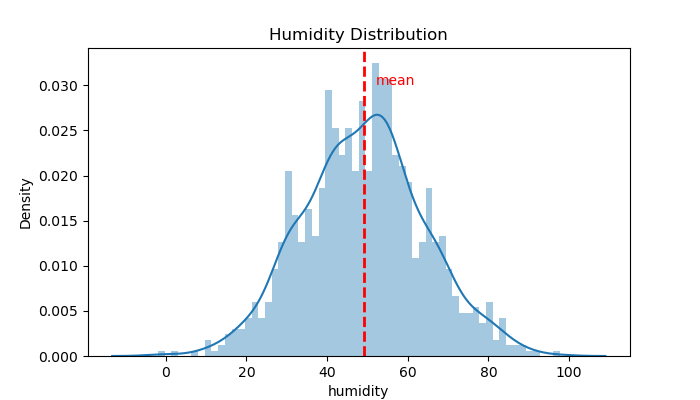

In [10]:
plt.figure(figsize=(7,4))
sns.distplot(sensors['humidity'],bins=60);
plt.title("Humidity Distribution")
plt.axvline(x=sensors['humidity'].mean(),color='red',ls='--',lw=2)
plt.text(sensors['humidity'].mean()+3,0.03, "mean", fontsize=10,c='red');

### EDA

In [11]:
%%sql
DROP TABLE IF EXISTS sensors_summary ;
SELECT madlib.summary (
    'sensors',  -- source_table
    'sensors_summary',  -- output_table
    NULL,  -- target_cols
    NULL,  -- grouping_cols
    TRUE,  -- get_distinct
    TRUE,  -- get_quartiles
    NULL,  -- quantile_array
    10,    -- how_many_mfv
    FALSE  -- get_estimate
);

SELECT * FROM sensors_summary LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
5 rows affected.


group_by,group_by_value,target_column,column_number,data_type,row_count,distinct_values,missing_values,blank_values,fraction_missing,fraction_blank,positive_values,negative_values,zero_values,mean,variance,confidence_interval,min,max,first_quartile,median,third_quartile,most_frequent_values,mfv_frequencies
None,None,"""timestamp""",1,timestamp,200000,200000,0,None,0.0,None,None,None,None,None,None,None,None,None,None,None,None,"['2019-07-25 11:00:00', '2019-12-01 19:00:00', '2019-11-03 16:00:00', '2019-11-23 21:00:00', '2019-11-26 21:00:00', '2019-12-21 14:00:00', '2020-01-03 09:00:00', '2019-11-30 16:00:00', '2019-12-15 03:00:00', '2019-11-05 15:00:00']","[202, 201, 197, 196, 196, 196, 196, 195, 194, 193]"
None,None,temperature,2,float8,200000,200000,0,None,0.0,None,200000,0,0,31.9994438435051,0.835176191508497,"[31.9954385889206, 32.0034490980896]",30.0085192011215,33.9926017682613,31.248024547442,31.9996683150071,32.7513196733315,"['31.0683580020357', '33.4404620759702', '31.8518097624841', '31.2395736874273', '31.9234761480272', '32.0675598337636', '31.97603187997', '32.3415347390407', '32.3491637421575', '32.0691435925339']","[199, 199, 197, 197, 196, 196, 196, 194, 194, 194]"
None,None,temperature_2,3,float8,200000,200000,0,None,0.0,None,200000,0,0,22.0030086462794,9.79313103261346,"[21.9892934553994, 22.0167238371594]",8.32724560294716,34.9790124846522,19.8896251104618,22.0010609443494,24.1215342578232,"['22.1431605091335', '21.9380489045486', '29.1471550234506', '25.3930850020541', '23.2334402542426', '23.3876663610782', '22.976330578986', '24.0853496925504', '20.1191750370896', '28.3660277203641']","[199, 198, 197, 196, 196, 196, 196, 196, 196, 194]"
None,None,humidity,4,float8,200000,200000,0,None,0.0,None,199909,91,0,50.0588710595491,225.421211109302,"[49.9930691551467, 50.1246729639516]",-17.5453267914932,111.003068656498,39.9191118821827,50.0933664649507,60.146228924528,"['40.375832605838', '54.705504582343', '22.9490141454464', '6.38816610085583', '85.8922776570054', '42.8604065548924', '69.4715691749291', '28.3485889328397', '48.8907605673007', '50.2516734047911']","[202, 199, 197, 196, 195, 195, 195, 194, 193, 193]"
None,None,pm25,5,float8,200000,200000,0,None,0.0,None,200000,0,0,95.0044919965079,233.936386396054,"[94.937458794959, 95.0715251980568]",19.3179702262465,168.412207316374,84.675736948759,95.0613261494482,105.313532682962,"['112.829199358041', '115.366822392534', '88.8385931658365', '104.74571223451', '107.951432952585', '73.3502768986271', '83.3066521223068', '108.927436418334', '104.339885274386', '79.4074759618029']","[199, 199, 198, 197, 197, 196, 195, 195, 195, 195]"


In [12]:
%%sql

DROP TABLE IF EXISTS temp_sensors_timeseries;

CREATE TABLE temp_sensors_timeseries(
    year INTEGER,
    month INTEGER,
    average_month_temperature FLOAT,
    average_pm25 FLOAT
);

INSERT INTO temp_sensors_timeseries 
    SELECT  date_part('year', timestamp) AS year,
            date_part('month', timestamp) AS month,
            avg(temperature) AS average_month_temperature, 
            avg(pm25) AS average_pm25
    FROM sensors
    GROUP BY year, month;
    
    
SELECT * FROM temp_sensors_timeseries ORDER BY year,month LIMIT 20;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
275 rows affected.
20 rows affected.


year,month,average_month_temperature,average_pm25
1997,3,31.4559509850083,91.1023284355867
1997,4,31.5075033968338,90.6496098287342
1997,5,31.5207432060795,88.7473181913066
1997,6,31.5498940661343,90.9763516211691
1997,7,31.5291402561777,90.2565569549733
1997,8,31.5099525488341,90.4449744791927
1997,9,31.5185634723824,89.7623233162467
1997,10,31.5014701004176,89.9192611233986
1997,11,31.5122468845025,90.3006817897654
1997,12,31.5671164373427,89.8338242354544


In [13]:
timeseries= %sql SELECT * FROM temp_sensors_timeseries ORDER BY year,month;
timeseries=timeseries.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
275 rows affected.


In [14]:
timeseries['date']=pd.DatetimeIndex(timeseries['year'].map("{:04}".format)+'-'+ timeseries['month'].map("{:02}".format))
timeseries.head()

,year,month,average_month_temperature,average_pm25,date
0,1997,3,31.455951,91.102328,1997-03-01
1,1997,4,31.507503,90.649610,1997-04-01
2,1997,5,31.520743,88.747318,1997-05-01
3,1997,6,31.549894,90.976352,1997-06-01
4,1997,7,31.529140,90.256557,1997-07-01


IntSlider(value=10, continuous_update=False, description='timeframe', max=200, min=10)

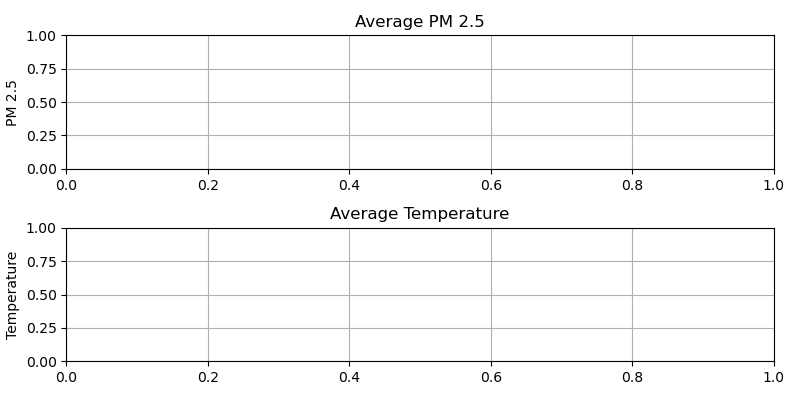

In [15]:
%matplotlib widget
f, (ax1,ax2) = plt.subplots(2,1,figsize=(8,4))

ax1.grid()
ax2.grid()

def update(change):
    ax1.plot(timeseries['date'][:change.new],timeseries['average_pm25'][:change.new],color='blue')
    ax2.plot(timeseries['date'][:change.new],timeseries['average_month_temperature'][:change.new],color='orange')
    f.canvas.draw()

slider = widgets.IntSlider(value=1,min=10,max=200,step=1,continuous_update=False,description='timeframe')

ax1.yaxis.set_label_text("PM 2.5")
ax1.title.set_text('Average PM 2.5')

ax2.title.set_text('Average Temperature')
ax2.yaxis.set_label_text('Temperature')
plt.tight_layout()

slider.observe(update,'value')
slider

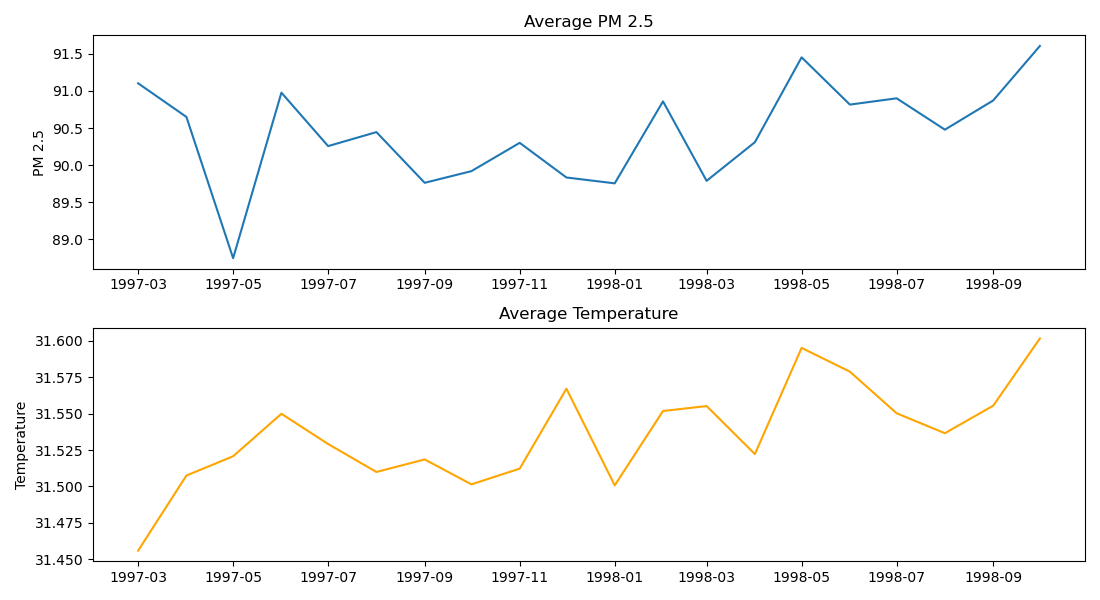

In [16]:
timeframe = 20

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(11,6))
ax1.plot(timeseries['date'][:timeframe],timeseries['average_pm25'][:timeframe])
ax2.plot(timeseries['date'][:timeframe],timeseries['average_month_temperature'][:timeframe],color='orange')

ax1.yaxis.set_label_text("PM 2.5")
ax1.title.set_text('Average PM 2.5')

ax2.title.set_text('Average Temperature')
ax2.yaxis.set_label_text('Temperature')
plt.tight_layout()

### Preprocess Data

Encode Month

```sql
CREATE FUNCTION parse_month(time_stamp timestamp)
  RETURNS char
AS $$
  from datetime import datetime
  date_obj=datetime.strptime(time_stamp,"%Y-%m-%d %H:%M:%S")
  return date_obj.strftime("%B")
$$ LANGUAGE plpythonu;
```

In [17]:
%%sql
SELECT *,parse_month(timestamp) FROM sensors WHERE pm25 > 160;

 * postgresql://gpadmin@192.168.133.128:31763/db
3 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,power,parse_month
2011-12-29 11:00:00,31.2442173089597,21.3114458078302,53.2443392511602,164.317432408163,81.8119491461205,December
2008-04-04 01:00:00,31.8158015123391,17.7931769572608,63.9649499130179,161.321242417883,82.0967066962878,April
2011-10-21 04:00:00,31.2724902369141,19.5216729895433,41.704738671421,168.412207316374,81.4544223880553,October


Create Month and rain Data

In [18]:
%%sql
DROP TABLE IF EXISTS sensors_pre;
CREATE TABLE sensors_pre
AS 
SELECT
    timestamp,
    temperature,
    temperature_2,
    humidity,
    pm25,
    parse_month(timestamp) AS month,           --- Month data
    CASE WHEN
            (humidity )>= 60
        THEN 1
        ELSE 0
    END as rain
FROM sensors;

SELECT * FROM sensors_pre LIMIT 10; 

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
200000 rows affected.
10 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,month,rain
1997-03-22 01:00:00,32.9213826233029,17.4826265348514,27.94636008953,98.7218237308808,March,0
1997-03-22 09:00:00,31.4649580939263,19.9532713965772,50.837115293311,91.2224507689739,March,0
1997-03-22 15:00:00,31.507048930815,25.3607691561948,47.6749079846652,86.7819015018054,March,0
1997-03-22 16:00:00,30.4884870878674,25.6856990011665,50.0666202536992,94.2610977261585,March,0
1997-03-22 18:00:00,32.0487564354404,21.4366298669406,39.3329266242551,99.7046310655581,March,0
1997-03-22 19:00:00,31.5786465584318,25.0848932771033,47.9579316951402,105.237201523011,March,0
1997-03-23 03:00:00,32.8667400873765,22.2964866341744,42.4368355289834,77.022908641646,March,0
1997-03-24 05:00:00,31.1649558178267,20.3564065988846,34.5042220287931,114.313694691625,March,0
1997-03-24 10:00:00,31.7998609150443,18.6352565135397,64.0707027124545,61.1112704124178,March,1
1997-03-24 20:00:00,30.9789716166604,18.1194939038757,37.5763779834305,90.1461292529732,March,0


In [19]:
%%sql
SELECT parse_month(timestamp) as month ,COUNT(*) as count  
    FROM sensors  
GROUP BY month ORDER BY count DESC;

 * postgresql://gpadmin@192.168.133.128:31763/db
12 rows affected.


month,count
December,17112
May,17112
August,17112
July,17112
October,17112
January,16688
March,16608
November,16560
June,16560
April,16560


### Encode categorical values

In [20]:
%%sql
DROP TABLE IF EXISTS sensors_encoded;


SELECT
madlib.encode_categorical_variables (
    'sensors_pre',
    'sensors_encoded',
    'month',
    NULL,  --categorical_cols_to_exclude     -- Optional
    NULL,  --row_id,                         -- Optional
    NULL,  --top,                            -- Optional
    NULL,  --value_to_drop,                  -- Optional
    NULL,  --encode_null,                    -- Optional
    NULL,  --output_type,                    -- Optional
    NULL,  --output_dictionary,              -- Optional
    NULL   --distributed_by                  -- Optional
);


SELECT * FROM sensors_encoded LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
5 rows affected.


timestamp,temperature,temperature_2,humidity,pm25,rain,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1997-03-22 06:00:00,31.3210691595019,18.0378154713855,69.1515112930262,101.454551704756,1,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-24 08:00:00,31.1746067733491,20.0659870783217,56.2763301155743,91.5364158256892,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-25 07:00:00,31.9373035574975,25.8062235988484,71.8780035677694,67.4303163133791,1,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-29 10:00:00,31.633976446782,25.4243524758717,54.0597027712871,68.7832288656276,0,0,0,0,0,0,0,0,1,0,0,0,0
1997-03-31 15:00:00,31.4546254950283,25.4530856992918,52.2239441211713,64.8614323853202,0,0,0,0,0,0,0,0,1,0,0,0,0


### Correlation

In [21]:
%%sql
DROP TABLE IF EXISTS sensors_correlations;
DROP TABLE IF EXISTS sensors_correlations_summary;

SELECT 
madlib.correlation(
    'sensors_encoded', -- source_table
    'sensors_correlations',  -- target_table
    'temperature,temperature_2,humidity,pm25,rain',
    TRUE -- verbose
)

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = sensors_correlationsProducing correlation for columns: temperature,temperature_2,humidity,pm25,rainTotal run time = ('sensors_correlations', 5, 6.099499225616455)"


In [22]:
Index = %sql SELECT variable FROM sensors_correlations ORDER BY column_position;
Index = Index.DataFrame();

columns =  ','.join(','.join('%s' %x for x in y) for y in Index.values)
print(columns)

 * postgresql://gpadmin@192.168.133.128:31763/db
5 rows affected.
temperature,temperature_2,humidity,pm25,rain


In [23]:
corr = %sql select variable,{columns} from sensors_correlations ORDER BY column_position;
corr = corr.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
5 rows affected.


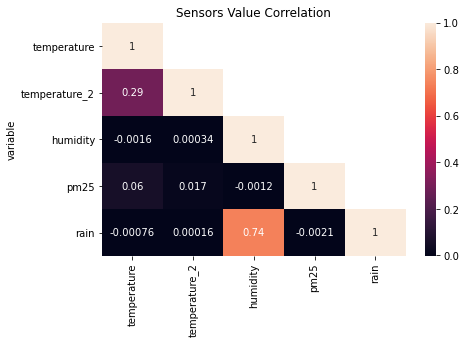

In [24]:
%matplotlib inline
corr_df=corr.set_index('variable')
plt.title('Sensors Value Correlation')
plt.tight_layout()
sns.heatmap(corr_df,annot=True);

### Split Data for training and testing

In [25]:
%%sql
DROP TABLE IF EXISTS sensors_split CASCADE;
DROP TABLE IF EXISTS sensors_split_train CASCADE;
DROP TABLE IF EXISTS sensors_split_test CASCADE;

SELECT madlib.train_test_split(
    'sensors_encoded', -- source_table,
    'sensors_split', -- output_table,
    0.7, -- train_proportion,
    NULL, -- test_proportion,
    NULL, -- grouping_cols,
    'temperature,temperature_2,rain,humidity,pm25,
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"', -- target_cols
    FALSE, -- with_replacement,
    TRUE -- separate_output_tables
);

SELECT COUNT(*) as "# In training set" FROM sensors_split_train;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
Done.
1 rows affected.
1 rows affected.


# In training set
140000


In [26]:
%%sql
SELECT * FROM sensors_split_train LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:31763/db
5 rows affected.


temperature,temperature_2,rain,humidity,pm25,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,month_November,month_December
30.0173311750415,19.3343147495518,0,19.4901626106699,90.3479644929762,0,0,0,0,1,0,0,0,0,0,0,0
30.0216768343846,22.0544695006666,1,77.3278564318079,141.447740363317,0,0,0,0,0,0,1,0,0,0,0,0
30.0277581559261,20.6442756349843,1,61.9923692043511,70.7391050841909,0,0,0,0,1,0,0,0,0,0,0,0
30.0339224466218,23.0906157044053,0,51.1453332061173,84.9332092198396,0,0,0,0,0,0,0,0,0,0,1,0
30.0343467821854,20.1613122757229,0,35.5910792405514,80.0190722405748,0,0,0,1,0,0,0,0,0,0,0,0


In [27]:
train_rain = %sql SELECT COUNT(*) FROM sensors_split_train WHERE rain = 1;
test_rain = %sql SELECT COUNT(*) FROM sensors_split_test WHERE rain = 1;

print("\nTotal rain in training set {}".format(train_rain[0][0]))
print("Total rain in testing set {}".format(test_rain[0][0]))

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.
 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.

Total rain in training set 35417
Total rain in testing set 15187


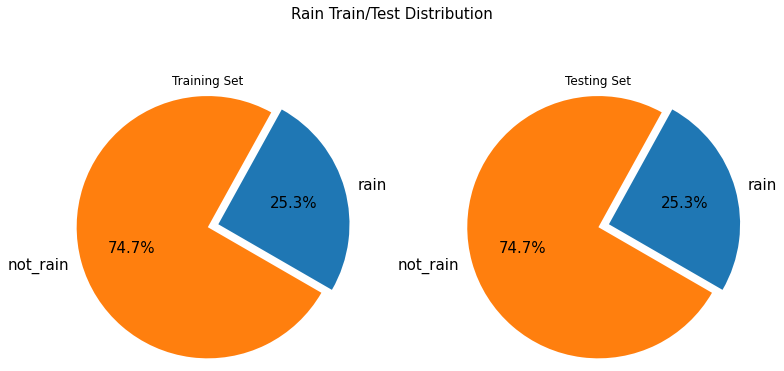

In [28]:
train_data=[train_rain[0][0],int((200000*0.7)-train_rain[0][0])]
test_data=[test_rain[0][0],int((200000*0.3)-test_rain[0][0])]

labels = ['rain','not_rain']

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,6))
f.patch.set_facecolor('white')
ax1.title.set_text('Training Set')
ax2.title.set_text('Testing Set')
f.suptitle("Rain Train/Test Distribution",fontsize=15)
ax1.pie(train_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15,},explode = [0.1, 0],startangle = -30);
ax2.pie(test_data,labels=labels,autopct="%.1f%%",radius=1.2,textprops={'fontsize': 15},explode = [0.1, 0], startangle = -30);
plt.tight_layout()

## Logistic Regresion ( Classification model )

In [5]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_model;
DROP TABLE IF EXISTS sensors_logreg_model_summary;

SELECT
    madlib.logregr_train(        -- Train the Logistic Regression Model
        'sensors_split_train',   -- source_table,
        'sensors_logreg_model',  -- out_table,
        'rain',                  -- labels,
        'ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]'       -- feature
        --, -- grouping_cols,
        --, -- max_iter,
        --, -- optimizer,
        --, -- tolerance,
        -- verbose
    )
;
SELECT * FROM sensors_logreg_model_summary ;           --- Get the summary table

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
1 rows affected.
1 rows affected.


method,source_table,out_table,dependent_varname,independent_varname,optimizer_params,num_all_groups,num_failed_groups,num_rows_processed,num_missing_rows_skipped,grouping_col
logregr,sensors_split_train,sensors_logreg_model,rain,"ARRAY[ 1, temperature, temperature_2, humidity,pm25, ""month_January"",""month_February"",""month_March"", ""month_April"",""month_May"",""month_June"", ""month_July"",""month_August"",""month_September"", ""month_October"",""month_November"",""month_December""]","optimizer=irls, max_iter=20, tolerance=0.0001",1,0,140000,0,None


In [6]:
logreg_coefs = %sql SELECT coef FROM sensors_logreg_model ;
logreg_coefs = logreg_coefs.DataFrame();

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.


In [7]:
logreg_coef_names = (
    'intercept',
    'temperature',
    'temperature_2',
    'humidity',
    'pm25',
    "month_January","month_February","month_March",
    "month_April","month_May","month_June","month_July",
    "month_August","month_September","month_October",
    "month_November","month_December"
)
tuple(zip(logreg_coef_names, logreg_coefs.iloc[0, 0]))

(('intercept', -15622.33267209),
 ('temperature', -0.147995271657574),
 ('temperature_2', -0.0672050385620664),
 ('humidity', 282.139733028604),
 ('pm25', 0.0239353480707959),
 ('month_January', -1302.15461576234),
 ('month_February', -1300.53485238174),
 ('month_March', -1301.70803989944),
 ('month_April', -1302.0547815848),
 ('month_May', -1302.58304509918),
 ('month_June', -1302.53856265989),
 ('month_July', -1301.34793683343),
 ('month_August', -1301.6961616867),
 ('month_September', -1301.43866379778),
 ('month_October', -1302.25021011806),
 ('month_November', -1301.99277043333),
 ('month_December', -1302.03386101354))

In [8]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_prob;
CREATE TABLE sensors_logreg_test_prob
AS
SELECT madlib.logregr_predict_prob(   --- Use the logistic regression model to estimate probability of mature
        coef, 
        ARRAY[
            1,
            temperature,
            temperature_2,
            humidity,
            pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June","month_July",
            "month_August","month_September","month_October",
            "month_November","month_December"]                   
    ) as pred,
    test.rain as y_test
FROM sensors_split_test test, sensors_logreg_model model;

SELECT * FROM sensors_logreg_test_prob LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
0.0,0
8.84745515865183e-124,0
0.0,0
0.0,0
1.0,1
1.0,1
1.0,1
8.02048292729922e-61,0
0.0,0
0.0,0


### Confusion Matrix

In [28]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_predict ;
CREATE TABLE sensors_logreg_test_predict
AS
SELECT
    (pred >= 0.5)::integer as pred,
    y_test
FROM sensors_logreg_test_prob;


SELECT * FROM sensors_logreg_test_predict LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
60000 rows affected.
10 rows affected.


pred,y_test
1,1
0,0
0,0
1,1
0,0
0,0
0,0
0,0
1,1
0,0


In [29]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_conf_matrix;
SELECT
madlib.confusion_matrix(
    'sensors_logreg_test_predict',
    'sensors_logreg_test_conf_matrix',
    'pred',  -- prediction_col
    'y_test' -- observation_col
);

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.


confusion_matrix
""


In [30]:
confusion = %sql SELECT \
                        confusion_arr[1] as "Predicted 0",\
                        confusion_arr[2] as "Predicted 1" \
                        FROM sensors_logreg_test_conf_matrix ORDER BY row_id;

confusion=confusion.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
2 rows affected.


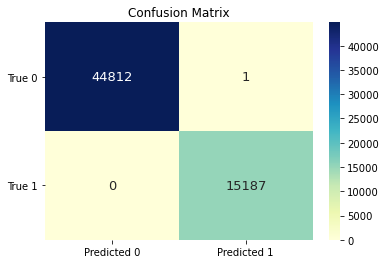

In [31]:
%matplotlib inline
plt.title('Confusion Matrix')
sns.heatmap(confusion.astype(int),annot=True,cmap="YlGnBu",fmt='d',yticklabels=['True 0','True 1'],annot_kws={"fontsize":13});
plt.yticks(rotation=0);

In [32]:
classification= %sql SELECT y_test,pred FROM sensors_logreg_test_predict;
classification=classification.DataFrame()

print(classification_report(classification['y_test'],classification['pred']))

 * postgresql://gpadmin@192.168.133.128:31763/db
60000 rows affected.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44813
           1       1.00      1.00      1.00     15187

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



### ROC

In [33]:
%%sql
DROP TABLE IF EXISTS sensors_logreg_test_auc;
SELECT
madlib.area_under_roc(
    'sensors_logreg_test_prob', 
    'sensors_logreg_test_auc', 
    'pred',  -- predictions, 
    'y_test'
);

SELECT * FROM sensors_logreg_test_auc;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
1 rows affected.


area_under_roc
1.000000000000000000000000000000000000000000000


## Linear Regression  ( Regression Model )

In [15]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_model;
DROP TABLE IF EXISTS sensors_linreg_model_summary;

SELECT madlib.linregr_train(
    'sensors_split_train',   -- source_table
    'sensors_linreg_model',  -- out_table
    'temperature_2',         -- labels
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    NULL,  -- grouping_cols
    TRUE  -- heteroskedasticity_option
);

SELECT * FROM sensors_linreg_model LIMIT 10;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
1 rows affected.
1 rows affected.


[([-8.9731595865966, 0.990882444864148, 0.000453847505403511, -7.32942755975254e-05, -0.759627003239913, -0.738929103605451, -0.794231495036283, -0.7504 ... (22 characters truncated) ... 031572572, -0.736991771496423, -0.723477173321947, -0.795086956234191, -0.745368179717828, -0.746887911155423, -0.725656100942916, -0.752815870422998], 0.0835364467887887, [0.262315375413009, 0.00879189183228088, 0.000534369745194247, 0.000525458009488665, 0.0343376415776303, 0.0356834511934803, 0.0344252562725332, 0.034 ... (22 characters truncated) ... 9914616035, 0.0344235496450635, 0.0342061893203681, 0.034215780500528, 0.0344314427361866, 0.0342673853286117, 0.0345644881273968, 0.0341854518994623], [-34.2075243300878, 112.704121452673, 0.849313625041653, -0.1394864561468, -22.1222823798936, -20.7078934041128, -23.0711861299918, -21.8182203349722, ... (2 characters truncated) ... 20.6520632500034, -21.4095228149173, -21.1504756214148, -23.2374344411615, -21.6478927539816, -21.7958827028395, -20.9942672452812, -22.0215275385855], [2.13562206274176e-255, 0.0, 0.39570825372092, 0.889065958397084, 2.96116296082895e-108, 4.086932178092e-95, 1.49630951222675e-117, 2.33713306398685e- ... (34 characters truncated) ... 628053424e-101, 3.90853201367553e-99, 3.21030966655712e-119, 9.42540371222718e-104, 3.80155529719642e-105, 1.0477242266257e-97, 2.72826573572697e-107], inf, 12.0819888491996, 0.67281280895703, 140000, 0, [[0.0688093561780678, -0.00225910569058429, -1.36688485675414e-05, -1.5861909776393e-05, 0.00572181948963528, 0.00576356517167428, 0.0057262835587797, ... (5375 characters truncated) ... 00416675381800656, 0.000418880526589261, 0.000418169221119412, 0.000418199721653263, 0.000420597520419082, 0.000419201603469278, 0.00116864512157045]])]

In [16]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict;

CREATE TABLE sensors_linreg_test_predict
AS
SELECT 
    madlib.linregr_predict(
        coef, 
        ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"
            ] 
    ) as prediction,
    test.temperature_2 as y_test
FROM sensors_split_test test, sensors_linreg_model model;

SELECT * FROM sensors_linreg_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
60000 rows affected.
5 rows affected.


prediction,y_test
22.0249418915196,24.2827845870469
22.1676333218757,22.878881957075
23.8660188749663,22.463237285746
22.4982772095861,23.9494611866169
20.3719095166408,20.9218431932262


In [17]:
%%sql
DROP TABLE IF EXISTS sensors_linreg_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_linreg_test_predict',      -- table_in
    'sensors_linreg_test_predict_mse',  -- table_out
    'prediction',  -- prediction
    'y_test'  -- y_test
);

SELECT * FROM sensors_linreg_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
8.92046307131852


In [34]:
pred = %sql SELECT * FROM sensors_linreg_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
200 rows affected.


In [35]:
pred

,prediction,y_test
0,22.024942,24.282785
1,22.167633,22.878882
2,23.866019,22.463237
3,22.498277,23.949461
4,20.371910,20.921843
...,...,...
195,22.876307,18.805454
196,22.638780,25.295263
197,23.554960,28.720290
198,21.883388,20.719570


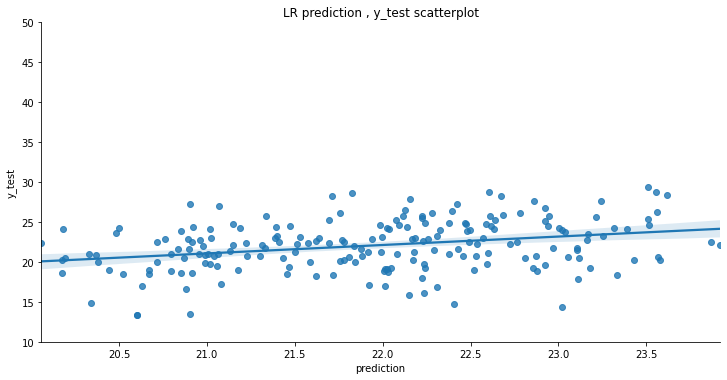

In [39]:
%matplotlib inline
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("LR prediction , y_test scatterplot") 
plt.ylim(10,50);

## Multilayer Perceptron ( ANN )

In [21]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_model;
DROP TABLE IF EXISTS sensors_mlp_model_standardization;

SELECT madlib.mlp_regression(
    'sensors_split_train',           -- source_table
    'sensors_mlp_model',             -- out_table
    'ARRAY[
        1,
        temperature,
        humidity,pm25,
        "month_January","month_February","month_March",
        "month_April","month_May","month_June",
        "month_July","month_August","month_September",
        "month_October","month_November","month_December"]',       -- feature
    'temperature_2',                 -- labels
    ARRAY[16],                       -- hidden_layer_sizes
    NULL,                            -- optimizer_params,
    NULL,                            -- activation,
    NULL,                            -- weights,
    NULL,                            -- warm_start,
    NULL,                            -- verbose,
    NULL                             -- grouping_col
);

SELECT * FROM sensors_mlp_model;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
Done.
1 rows affected.
1 rows affected.


[([-4.58768589174495, 0.144408205385255, 1.296777219013, -0.250531755296532, 0.016938042861642, -0.105379548023169, -0.0120771494931798, -0.031266689283 ... (5415 characters truncated) ... 0.529684390774751, 5.17003351008293, 0.500742825374973, 0.490411554057279, 0.426736310833832, 0.469863799953791, 0.273483367661748, 0.511077063898507], 5.56379025206824, 52)]

Mean and Standard Deviation for normalizing inputs

In [22]:
%%sql

SELECT * FROM sensors_mlp_model_standardization;

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.


mean,std
"[1.0, 32.000508810203, 50.0662596592155, 95.0057424307633, 0.0838214285714286, 0.07375, 0.0831357142857143, 0.0827785714285714, 0.0855214285714286, 0.0832, 0.0853357142857143, 0.0851, 0.0834714285714286, 0.08525, 0.0827, 0.0859357142857143]","[1.0, 0.913595486106037, 15.002365296593, 15.2858804331399, 0.277119823693061, 0.261363611660078, 0.276087245804507, 0.275547236496424, 0.279656063453898, 0.276184286301737, 0.279380618785665, 0.279030446367417, 0.276593472778505, 0.279253357186624, 0.275428230216149, 0.280269098003898]"


In [23]:
%%sql
SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'ARRAY[
            1,
            temperature,
            humidity,pm25,
            "month_January","month_February","month_March",
            "month_April","month_May","month_June",
            "month_July","month_August","month_September",
            "month_October","month_November","month_December"]',
        'sensors_mlp_test_predict',
        'response'
    );

 * postgresql://gpadmin@192.168.133.128:31763/db
1 rows affected.


mlp_predict
""


In [24]:
%%sql
DROP TABLE IF EXISTS sensors_mlp_test_predict;

SELECT 
    madlib.mlp_predict(
        'sensors_mlp_model',
        'sensors_split_test',
        'temperature_2',
        'sensors_mlp_test_predict',
        'response'
    );
    
SELECT * FROM sensors_mlp_test_predict LIMIT 5;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
5 rows affected.


temperature_2,estimated_temperature_2
21.7004712521324,23.1298032299375
21.6717807378192,23.1406121015711
14.3885708611461,23.0887210542185
22.5694267492201,23.2186148409888
24.8544872407643,23.253549463613


In [25]:
%%sql 
DROP TABLE IF EXISTS sensors_mlp_test_predict_mse;

SELECT madlib.mean_squared_error(
    'sensors_mlp_test_predict',      -- table_in
    'sensors_mlp_test_predict_mse',  -- table_out
    'estimated_temperature_2',  -- prediction
    'temperature_2'  -- y_test
);

SELECT * FROM sensors_mlp_test_predict_mse;

 * postgresql://gpadmin@192.168.133.128:31763/db
Done.
1 rows affected.
1 rows affected.


mean_squared_error
11.0476547588557


In [41]:
pred = %sql SELECT temperature_2 as y_test, estimated_temperature_2 as prediction FROM sensors_mlp_test_predict LIMIT 200;
pred=pred.DataFrame()

 * postgresql://gpadmin@192.168.133.128:31763/db
200 rows affected.


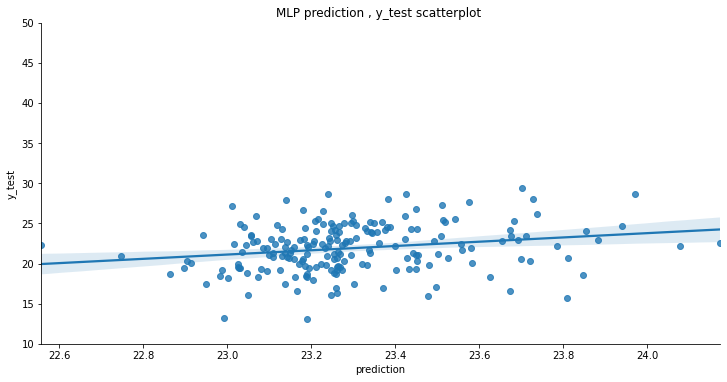

In [42]:
sns.lmplot(x='prediction',y='y_test',data=pred,height=5,aspect=2)
plt.title("MLP prediction , y_test scatterplot ") 
plt.ylim(10,50);